# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [51]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt 

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, 
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D,
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate )

from chxanalys.Two_Time_Correlation_Function import show_C12, get_one_time_from_two_time


from chxanalys.chx_compress_analysis import ( compress_eigerdata, Multifile,get_t_iqc,
                                            get_each_ring_mean_intensityc)

from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc)


%matplotlib notebook

## Make a directory for saving results

In [3]:
CYCLE = '2016_2'

username = getpass.getuser()

#username = "Leheny"

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'


os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [4]:
###
uid = 'fd7ad2'  # Dendrite particles PHYS10_32.5, T=30C, 10k frames x .01 s
uid = 'f78ce3'   # PHYS10_32.5, T=26.7C, 10k frames x .00134 s )
uid = '4012c6ef'  # PHYS10_32.5, T=40C, 10k frames x .00134 s )
uid = '7f50faa4'   # PHYS10_32.5, T=40C, 10k frames x .00134 s )
uid = 'f2e473ab'   # PHYS10_27, T=RT, 10k frames x .00134 s  1st series)


# Don't Change these lines below here

In [5]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  1973--f2e473ab-33f9-4043-b4ef-f820f889b175--/XF11ID/data/2016/07/07/f8c12574-d321-460f-b234_9975


In [6]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/07/07/f8c12574-d321-460f-b234_9975_master.h5


In [7]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [8]:
md

{'beam_center_x': 1231.0,
 'beam_center_y': 905.0,
 'count_time': 0.00133,
 'detector_distance': 4.8400002,
 'frame_time': 0.00134,
 'framerate': 746.26867962085441,
 'incident_wavelength': 1.2846771,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [9]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000      # detector to sample distance (mm)

exposuretime= md['count_time']
acquisition_period = md['frame_time']

timeperframe =exposuretime

#center = [  1338, 2167 - 424  ]  # center of the speckle pattern

center = [   1227,1261  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[1], center[0]]
print (center)



[1261, 1227]


In [10]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)

In [11]:
setup_pargs

{'Ldet': 4840.0,
 'center': [1261, 1227],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'timeperframe': 0.00133,
 'uid': 'f2e473ab'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [12]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'a029ca_mask.npy'

<IPython.core.display.Javascript object>


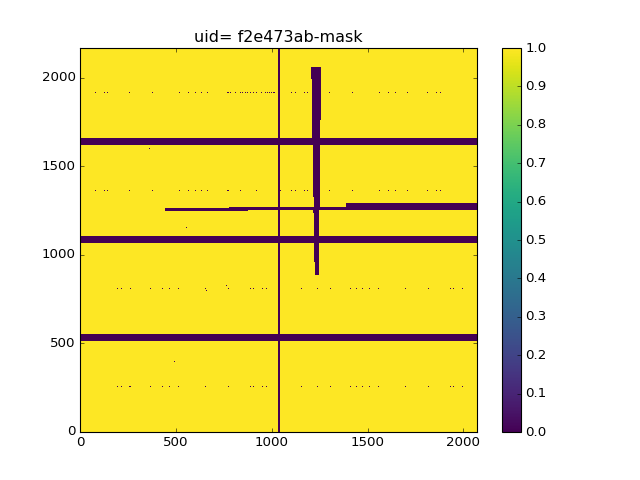

In [13]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

In [20]:
#show_img( imgsa[0],  vmin=0.01, vmax=.5, logs=False, image_name= 'uid= %s'%uid) 

In [21]:
imgsa = apply_mask( imgs, mask )

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [28]:
filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]

In [29]:
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                        force_compress=False, bad_pixel_threshold=5e4,nobytes=4)

Averaging images:   1%|          | 65/10000 [00:00<00:15, 649.96it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_f2e473ab-33f9-4043-b4ef-f820f889b175.cmp.


Get each frame intensity: 100%|██████████| 10000/10000 [00:02<00:00, 3585.09it/s]

Bad frame list are: [ 253  258 4094 4701 7897]


In [30]:
%system ls -lh {sud[2][0]+"*"}|tail -2 ; ls -lh {filename}

['-rw-r--r-- 1 softioc softioc 15M Jul  7 17:59 /XF11ID/data/2016/07/07/f8c12574-d321-460f-b234_9975_data_000100.h5',
 '-rw-r--r-- 1 softioc softioc 88M Jul  7 17:56 /XF11ID/data/2016/07/07/f8c12574-d321-460f-b234_9975_master.h5',
 '-rw-r--r-- 1 yuzhang yuzhang 1.5G Jul 10 22:39 /XF11ID/analysis/Compressed_Data/uid_f2e473ab-33f9-4043-b4ef-f820f889b175.cmp']

In [31]:
15*100+88

1588

In [32]:
print ('The bad frame list is: %s'% bad_frame_list)
print ('The number of bad frames is : %s '%len(bad_frame_list))

The bad frame list is: [ 253  258 4094 4701 7897]
The number of bad frames is : 5 


<IPython.core.display.Javascript object>


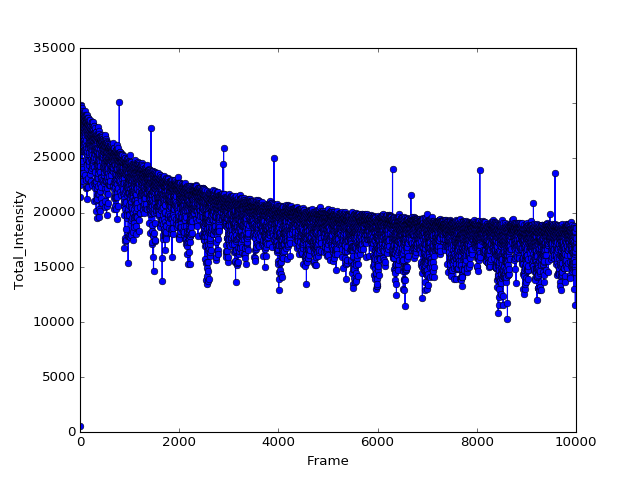

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [33]:
plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
       title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend=''   )

In [34]:
min_inten = 10
good_start = np.where( np.array(imgsum) > min_inten )[0][0]
print ('The good_start frame number is: %s '%good_start)

The good_start frame number is: 0 


## Plot intensity average image

<IPython.core.display.Javascript object>


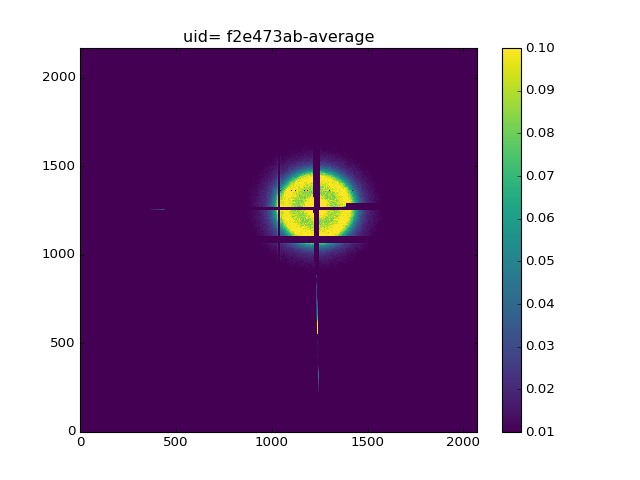

In [35]:
show_img( avg_img,  vmin=0.01, vmax=.1, logs=False, image_name= 'uid= %s-average'%uid) 

## Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


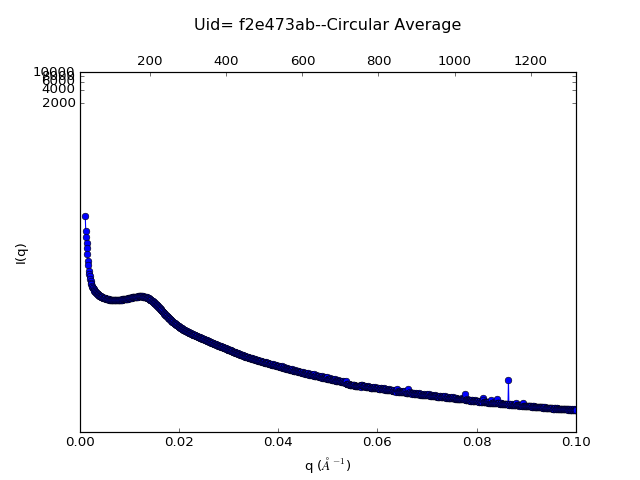

In [36]:
qp, iq, q = get_circular_average( avg_img, mask, pargs=setup_pargs, 
                    plot_ = True, plot_qinpixel=False, xlim=[0.0001,.1], ylim = [.0001, 10000])

In [37]:
#save_lists( [q,iq], ['q','iq'], filename= 'I(q)-uid=%s'%uid, path=data_dir)

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings

In [38]:
inner_radius= 20
outer_radius = 500
width = 20
num_rings = 24


In [39]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 

<IPython.core.display.Javascript object>


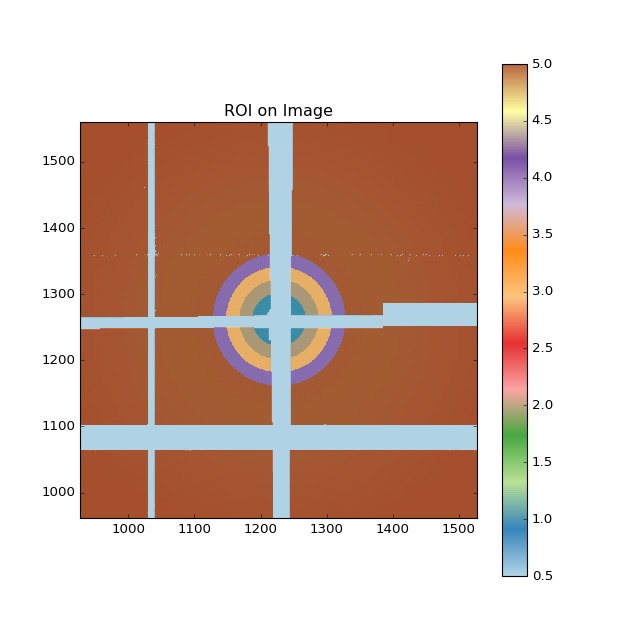

In [40]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=300, alpha=.9)

<IPython.core.display.Javascript object>


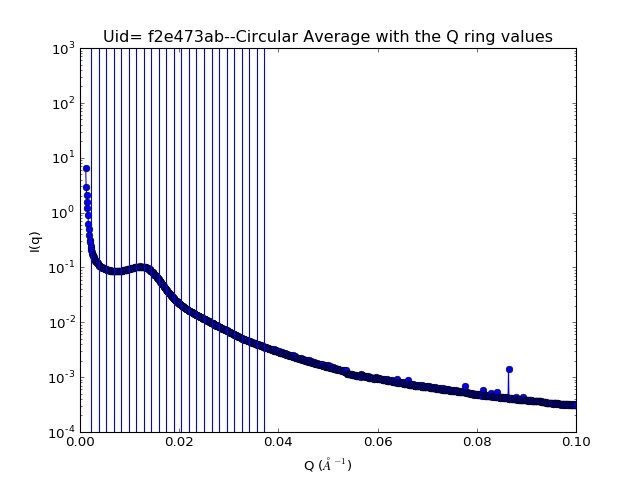

In [41]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.00001,.1], ylim = [1e-4, 1000])

## Check one ring intensity

<IPython.core.display.Javascript object>


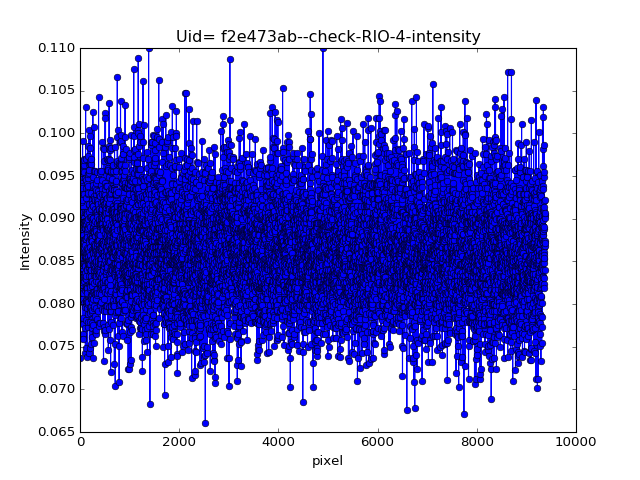

In [42]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 4, uid =uid )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [43]:
good_series = apply_mask( imgsa[good_start:], mask )

In [44]:
FD = Multifile(filename, 0, len(imgs))

In [45]:
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width=50, edges = None )

Averaging images: 100%|██████████| 50/50 [00:00<00:00, 224.22it/s]


<IPython.core.display.Javascript object>


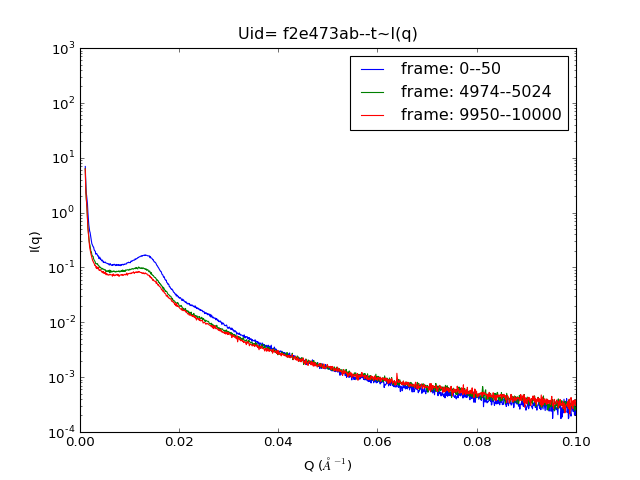

In [46]:
qp, iqs, q = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,   xlim=[0.0001,.1], ylim = [0.0001, 1000])

Get ROI intensity of each frame: 100%|██████████| 10000/10000 [00:04<00:00, 2086.38it/s]


<IPython.core.display.Javascript object>


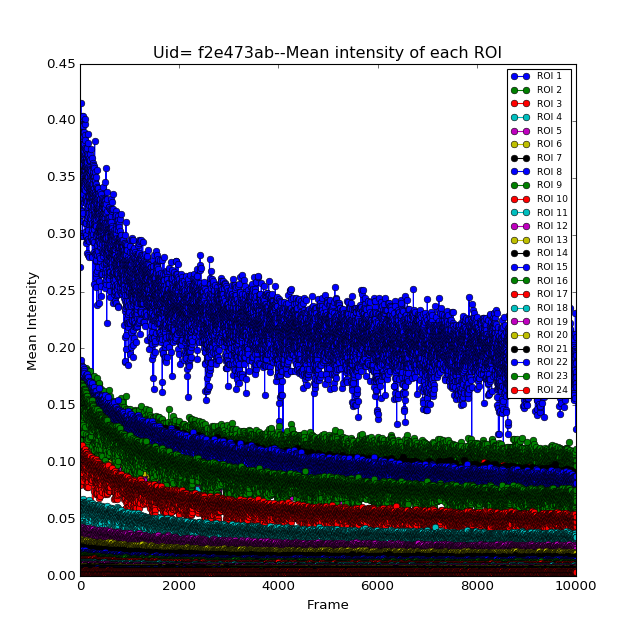

In [47]:
times, mean_int_sets = get_each_ring_mean_intensityc(FD, ring_mask,
                                    timeperframe = None, plot_ = True, uid = uid  )

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [48]:
if False:
    good_start = 0
    good_end =  1000
    good_series = apply_mask( imgs[good_start:good_end-1], mask )
    

In [49]:
lag_steps = None

In [55]:
t0 = time.time()
g2, lag_steps  =cal_g2c( FD,  ring_mask, 
                       bad_frame_list,good_start, num_buf = 8, imgsum= None )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--12--
Bad frame involved and will be precessed!
10000 frames will be processed...


100%|██████████| 10000/10000 [14:50<00:00, 10.89it/s]

G2 calculation DONE!
Total time: 14.85 min


In [59]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

In [60]:
save_saxs_g2(   g2, res_pargs )

The g2 is saved in /XF11ID/analysis/2016_2/yuzhang/Results/ with filename as g2-uid=f2e473ab-20160711-1710-.csv


### Plot the one time correlation functions

<IPython.core.display.Javascript object>


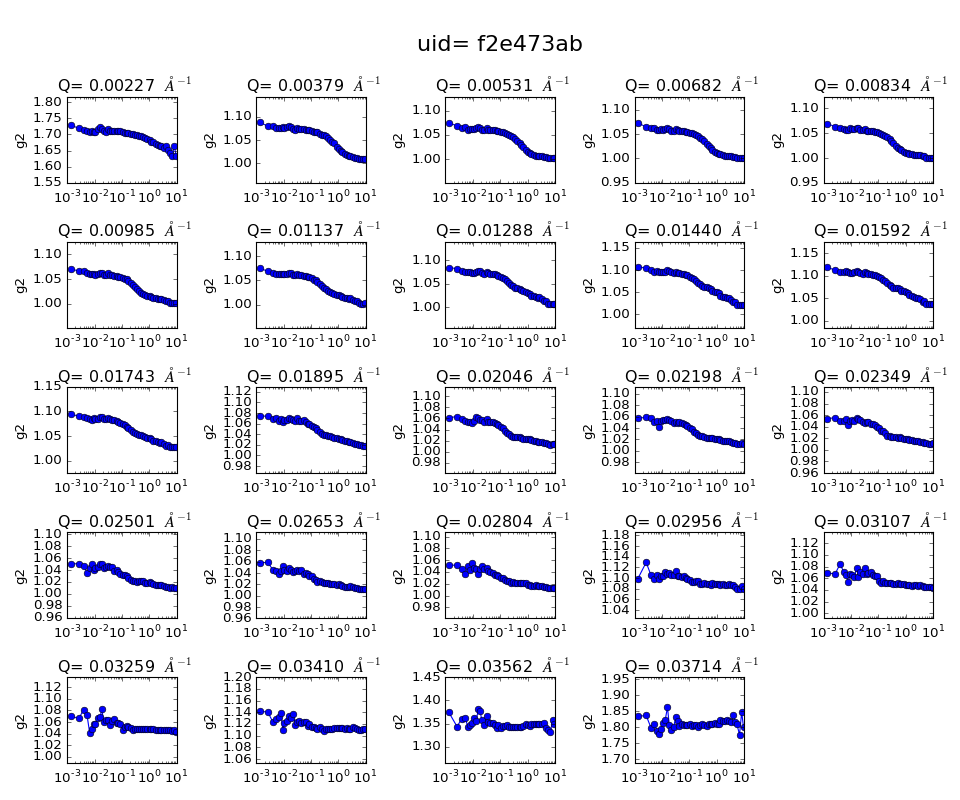

In [61]:
plot_saxs_g2( g2_, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs)     

# Fit g2

In [62]:
fit= True

<IPython.core.display.Javascript object>


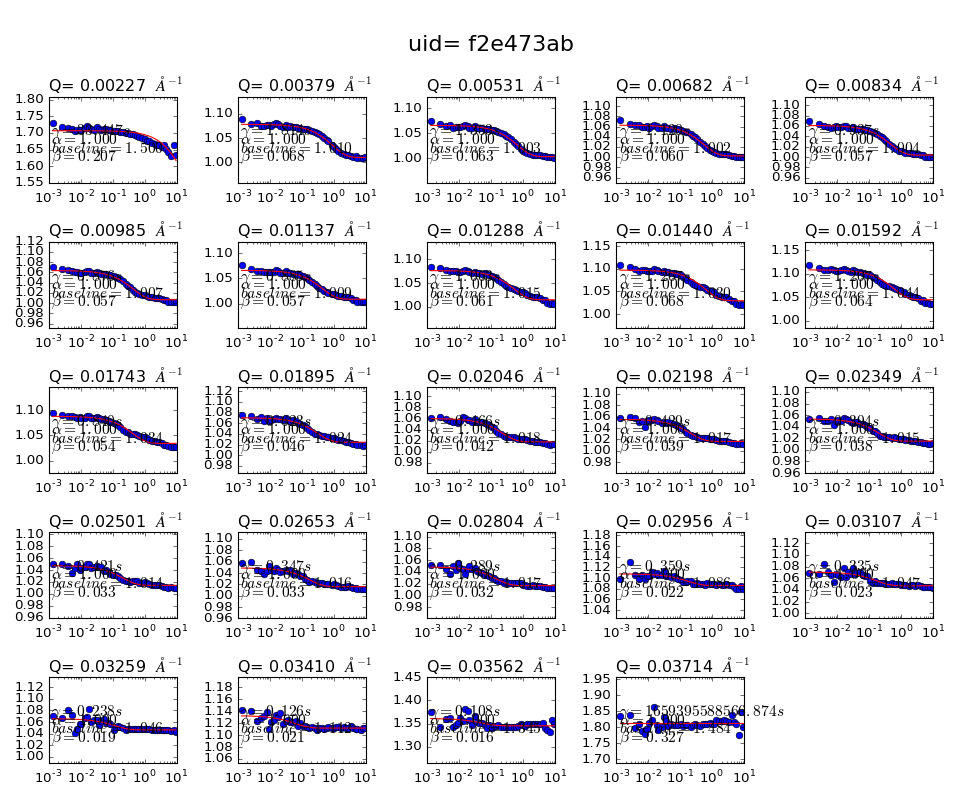

In [63]:
if fit:
   # result = fit_saxs_g2( g2, res_pargs, function = 'simple',  vlim=[0.95, 1.05],)
   result = fit_saxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                guess_values={'baseline':1.0,'beta':0.1,'alpha':1.0,'relaxation_rate':0.01})
   

In [66]:
#fig,ax=plt.subplots()
#q_nums = [10,15,20]
#for q_num in q_nums:
#    plot1D(ax=ax, x=taus[1:], y= np.array( g2 )[1:,q_num ], logx=True)

The fitted diffusion coefficient D0 is:  3.873e+03   A^2S-1


<IPython.core.display.Javascript object>


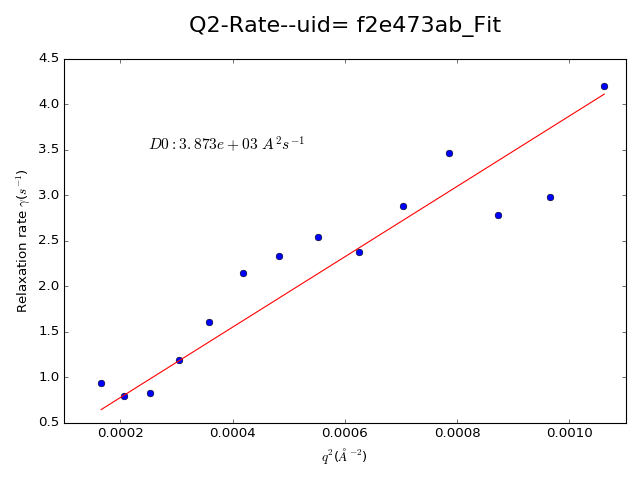

3873.4447783599262

In [71]:
fit_q_rate(  q_ring_center[7:-3], result['rate'][7:-3], power_variable=False,uid=uid, path= data_dir )
#fit_q_rate(  q_ring_center, result['rate'], power_variable=False,uid=uid, path= data_dir )

In [ ]:
#fig,ax=plt.subplots()
#q_nums = [10,45]
#for q_num in q_nums:
#    plot1D(ax=ax, x=data.tau[1:], y= np.array( data )[1:,q_num + 1], logx=True, legend= 'q=%.5f'%float(data.columns[q_num+1]) )

 

In [ ]:
#import matplotlib.pyplot as plt
#plt.figure()
#plt.plot(q_ring_center,result['rate'])
#plt.loglog()
#plt.show()

# For two-time

In [ ]:
FD = Multifile(filename, 0, Nimg)

In [75]:
run_two_time = True

In [76]:
if run_two_time: 
    data_pixel =   Get_Pixel_Arrayc( FD,pixelist ).get_data()

100%|██████████| 10000/10000 [00:29<00:00, 339.03it/s]


In [79]:
if run_two_time: 
    g12b = auto_two_Arrayc(  data_pixel,  ring_mask, index = None   )

100%|██████████| 24/24 [12:59<00:00, 54.28s/it]


<IPython.core.display.Javascript object>


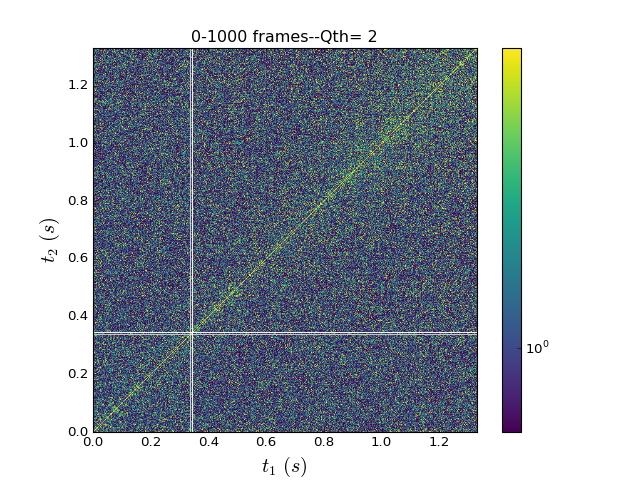

In [81]:
if run_two_time:
    show_C12(g12b, q_ind=2, N1=0, N2=1000, vmin=.95, vmax=1.2, timeperframe=timeperframe )

In [82]:
if run_two_time:

    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
    max_taus= lag_steps.max()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    taus2 = np.arange( g2b.shape[0])[:max_taus] *timeperframe
    res_pargs2 = dict(taus=taus2, q_ring_center=q_ring_center, path=data_dir, uid=uid        )
    save_saxs_g2(   g2b,  res_pargs2, taus=np.arange( g2b.shape[0]) *timeperframe, filename='g2_from_two-time')

The g2 is saved in /XF11ID/analysis/2016_2/yuzhang/Results/ with filename as g2_from_two-time-uid=f2e473ab-20160711-1730-.csv


<IPython.core.display.Javascript object>


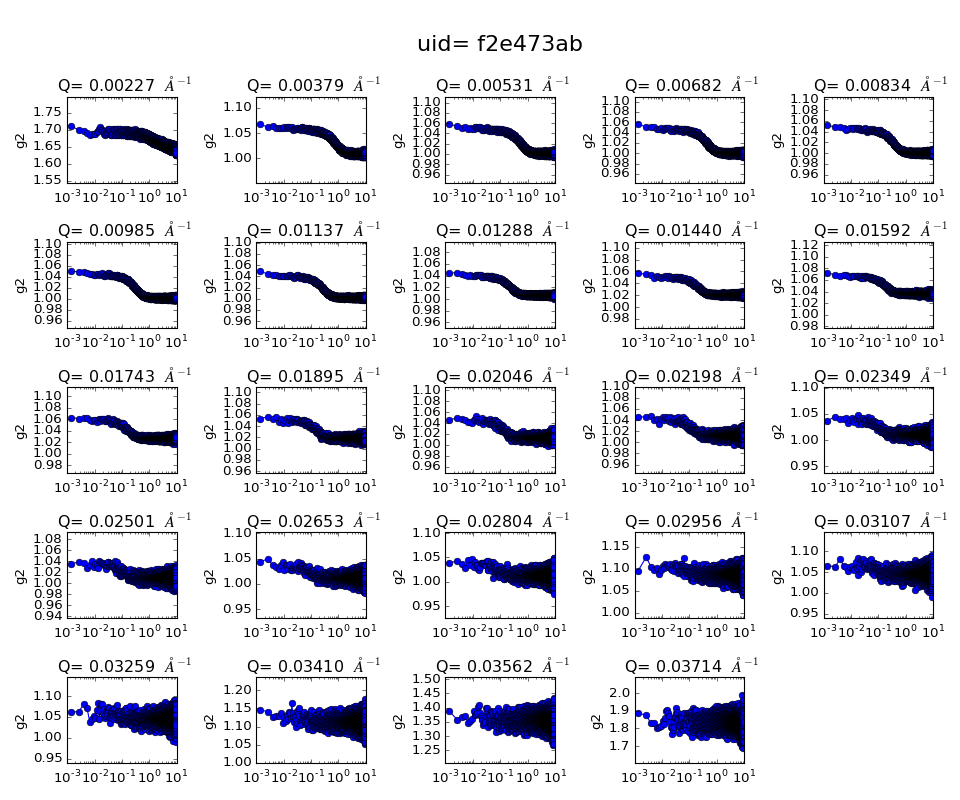

In [83]:
if run_two_time:
    plot_saxs_g2( g2b, taus2,  vlim=[0.95, 1.05], res_pargs=res_pargs2)  

<IPython.core.display.Javascript object>


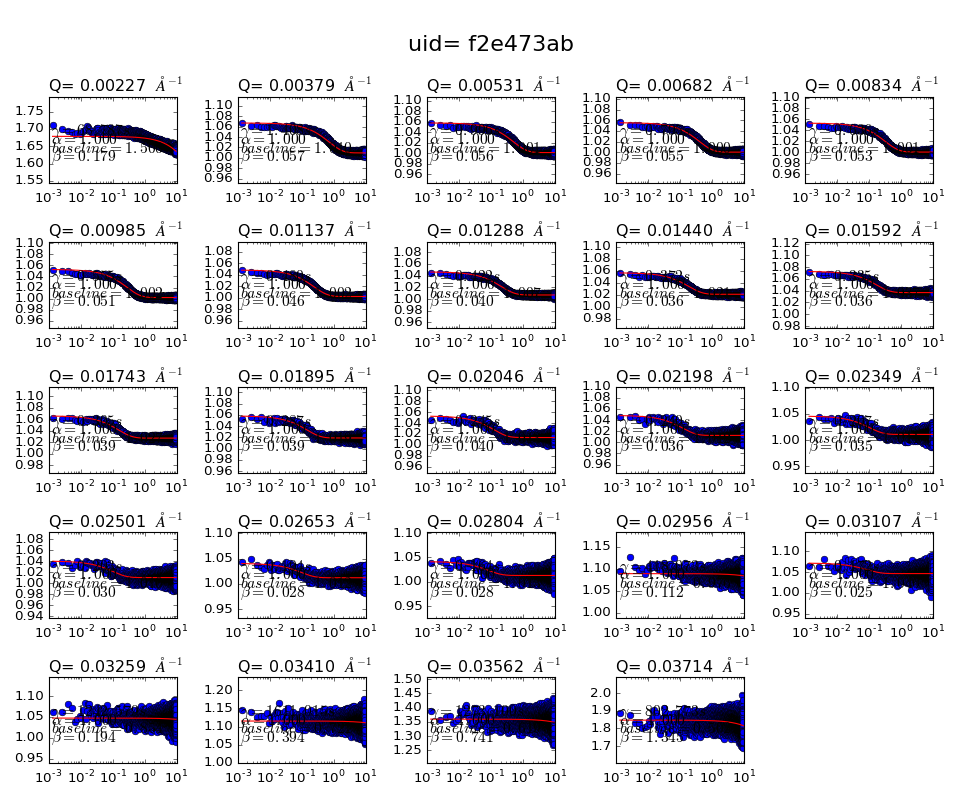

The fitted diffusion coefficient D0 is:  8.718e+03   A^2S-1


<IPython.core.display.Javascript object>


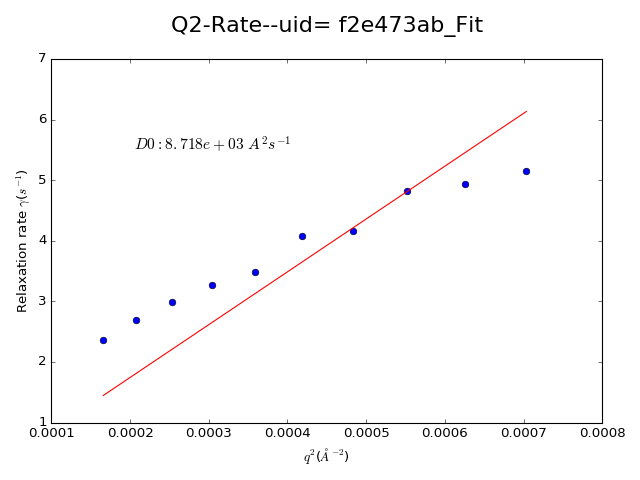

In [88]:
if run_two_time:
    result2 = fit_saxs_g2( g2b, res_pargs2, function = 'simple')#, fit_range= [0, 2000 ])
    fit_q_rate(  q_ring_center[7:-7], result2['rate'][7:-7], uid=uid, path= data_dir )
    save_lists( [q_ring_center**2,result2['rate']], ['q2','rate'], filename= 'Q2-rate-twoT-uid=%s'%uid, path= data_dir)

<IPython.core.display.Javascript object>


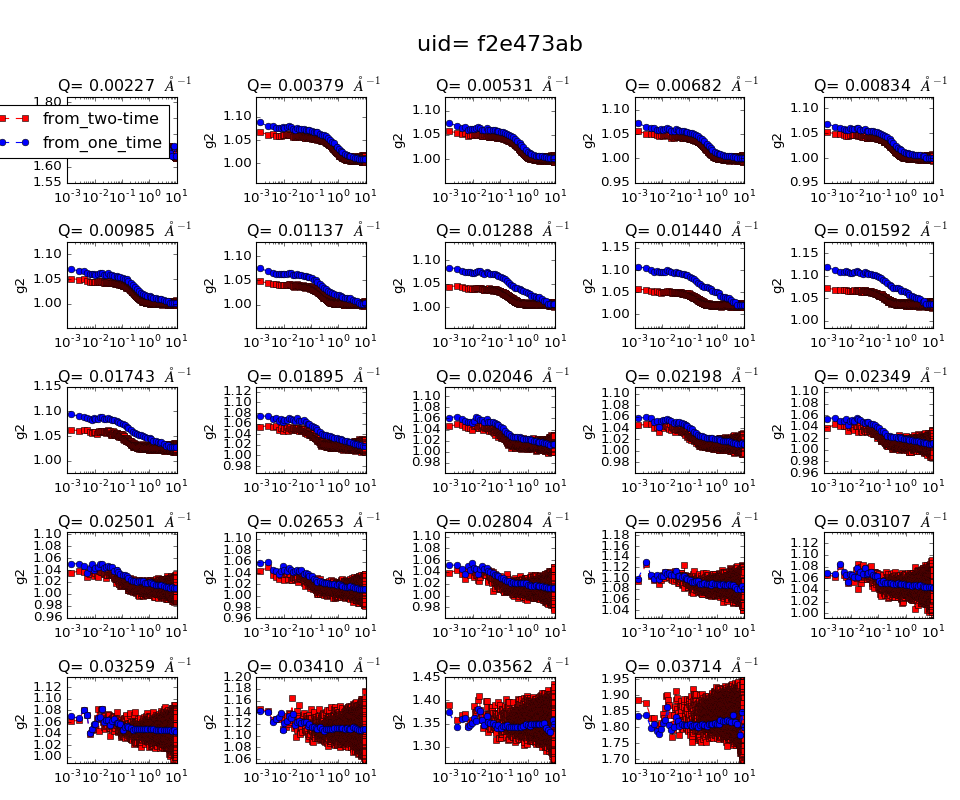

In [85]:
if run_two_time:
    plot_saxs_two_g2( g2, taus, 
                 g2b, taus2,
                 res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid )

# The End!